<a href="https://colab.research.google.com/github/DavidMartinezGonzalez/TutorialOnNeuralVocoders/blob/main/chapter_4_DSP_based_Vocoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome


This is the hands-on session for ICASSP 2022 short course **Inclusive Neural Speech Synthesis**, **LECTURE 1, neural vocoder**.

Click [HERE](https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7?usp=sharing) to go back to the entry point of this hands-on session.


## About this book

In this notebook, we will use the famous [SPTK](https://github.com/sp-nitech/SPTK) to do copy-synthesis. SPTK is released under the Modified BSD license. See [README here](http://sp-tk.sourceforge.net/readme.php).


Note that:
1. SPTK is based on C/C++;
2. There is a Python wrapper over it -- [PySPTK](https://pysptk.readthedocs.io/en/latest/);
3. There is also under-development [Pytorch-based differentiable SPTK](https://github.com/sp-nitech/diffsptk);

We will follow [the official notebook](https://colab.research.google.com/drive/1spX1v9mk6Itxa63R4wYwekzduvLeaUmE?usp=sharing) to demonstrate the usage. The original notebook was made by [Dr. Takenori Yoshimura](https://www.sp.nitech.ac.jp/~takenori/), released without a license. We made a few modifications.

## Preparation

Download some files for demonstration.

In [1]:
!echo "Download external zip "
!wget --quiet --show-progress -O iNSS.zip https://www.dropbox.com/sh/bua2vks8clnl2ha/AABxjrZhQBRM1YEekjWs8Pl2a/iNSS
!echo "Unzip files"
!unzip -q -o iNSS.zip -x / -d /content
!if [ -d "/content/data_models" ]; then echo "Done"; else echo "Please contact with the author"; fi

Download external zip 
iNSS.zip            100%[===================>] 402.88M  51.8MB/s    in 9.5s    
Unzip files
Done


Install the SPTK and required tools

In [10]:
!apt-get install sox
!git clone https://github.com/sp-nitech/SPTK.git
!cd SPTK; make -j 5

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 18 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopencore-amrnb0 amd64 0.1.5-1 [94.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopencore-amrwb0 amd64 0.1.5-1 [49.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libsox3 amd64 14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1 [240 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libs

In [11]:
%env PATH=/content/SPTK/bin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin

env: PATH=/content/SPTK/bin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin


In [12]:
# At the begining, let's load packages
from __future__ import absolute_import
from __future__ import print_function
import os
import sys
import numpy as np

# misc functions for this demonstration book
import plot_lib
import tool_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

from IPython.display import Image

# Sec.1 Extract Acoustic Features

We will use the SPTK tools to extract Mel-cepstrum features and F0. The former encodes the spectral envelope.

## Load waveform


SPTK expects an input waveform in binary format (short int16) without WAV head.

In [13]:
filename = 'slt_arctic_b0474'
%env FILENAME=slt_arctic_b0474
!sox -t wav /content/data_models/acoustic_features/hn_nsf/${FILENAME}.wav -t s16 /content/${FILENAME}.short

env: FILENAME=slt_arctic_b0474


## Mel-cepstrum feature

Following the official recipe, we do
* Frame shift = 80 points (= 5 ms)
* Frame length = 400 points (= 25 ms)
* FFT length = 512 points
* Blackman window
* Warping factor = 0.42 (this is suitable for 16 kHz)
* Order of coefficients = 24


In [14]:
# Extract Mel-cepstrum feature
!x2x +sd /content/${FILENAME}.short | \
    frame -l 400 -p 80 | \
    window -l 400 -L 512 -w 0 | \
    mgcep -l 512 -m 24 -a 0.42 | x2x +df  > /content/${FILENAME}.mgc

In [15]:
# Sanity check, we can convert mgc to spectral envelope
!x2x +fd /content/${FILENAME}.mgc | mgc2sp -l 512 -m 24 -a 0.42 | x2x +df > /content/${FILENAME}_1.spec

# We can extract the spectra
!x2x +sd /content/${FILENAME}.short | \
    frame -l 400 -p 80 | \
    window -l 400 -L 512 | \
    spec -l 512  | x2x +df > /content/${FILENAME}_2.spec

In [16]:
# We can load the SPTK output (little-endian, float32)
dim = 512 // 2 + 1
mel_spec = tool_lib.read_raw_mat('/content/{:s}_1.spec'.format(filename), dim)
orig_spec = tool_lib.read_raw_mat('/content/{:s}_2.spec'.format(filename), dim)

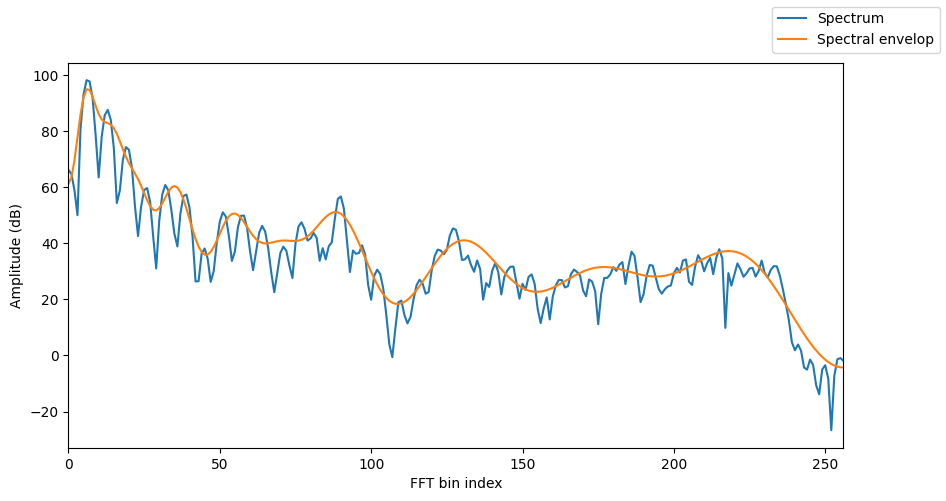

In [17]:
frame_idx = 100

fig = plt.figure()
axis = fig.add_subplot(111)

plot_lib.plot_signal(orig_spec[frame_idx], fig, axis)
plot_lib.plot_signal(mel_spec[frame_idx], fig, axis,
                     xlabel='FFT bin index', ylabel='Amplitude (dB)')
fig.legend(['Spectrum', 'Spectral envelop'])

## F0 extraction

We follow the original implementation
* Frame shift = 80 points (= 5 ms)
* Lower frequency = 60 Hz
* Upper frequency = 200 Hz
* Sample rate = 16 kHz
* Algorithm = RAPT

In [18]:
!pitch --help

pitch: unrecognized option '--help'

 pitch - pitch extraction

  usage:
       pitch [ options ] [ infile ] > stdout
  options:
       -a a  : algorithm used for pitch      (   int)[    0][    0 <= a <= 4     ]
               estimation
                 0 (RAPT)
                 1 (SWIPE')
                 2 (REAPER)
                 3 (DIO)
                 4 (Harvest)
       -p p  : frame shift [point]           (   int)[   80][    1 <= p <=       ]
       -s s  : sampling rate [kHz]           (double)[   16][  6.0 <  s <= 98.0  ]
       -L L  : minimum fundamental frequency (double)[   60][ 10.0 <  L <  H     ]
               to search for [Hz]
       -H H  : maximum fundamental frequency (double)[  240][    L <  H <  500*s ]
               to search for [Hz]
       -t0 t : voicing threshold for RAPT    (double)[    0][ -0.6 <= t <= 0.7   ]
       -t1 t : voicing threshold for SWIPE'  (double)[  0.3][  0.2 <= t <= 0.5   ]
       -t2 t : voicing threshold for REAPER  (double)[  0.9]

In [22]:
# Extract F0 using default RAPT
!x2x +sd /content/${FILENAME}.short | \
    pitch -p 80 -L 60 -H 200 -s 16 -o 0 > ${FILENAME}_1.pit

!sopr -magic 0 -INV -m 16000 -MAGIC 0 ${FILENAME}_1.pit | x2x +df > ${FILENAME}_1.f0

# Extract F0 using SWIPE
!x2x +sd /content/${FILENAME}.short | \
    pitch -a 1 -p 80 -L 60 -H 200 -s 16 -o 0 > ${FILENAME}_2.pit

!sopr -magic 0 -INV -m 16000 -MAGIC 0 ${FILENAME}_2.pit | x2x +df > ${FILENAME}_2.f0

# Extract F0 using REAPER
!x2x +sd /content/${FILENAME}.short | \
    pitch -a 2 -p 80 -L 60 -H 200 -s 16 -o 0 > ${FILENAME}_3.pit

!sopr -magic 0 -INV -m 16000 -MAGIC 0 ${FILENAME}_3.pit | x2x +df > ${FILENAME}_3.f0

# Extract F0 using WORLD
!x2x +sd /content/${FILENAME}.short | \
    pitch -a 3 -p 80 -L 60 -H 200 -s 16 -o 0 > ${FILENAME}_4.pit

!sopr -magic 0 -INV -m 16000 -MAGIC 0 ${FILENAME}_4.pit | x2x +df > ${FILENAME}_4.f0


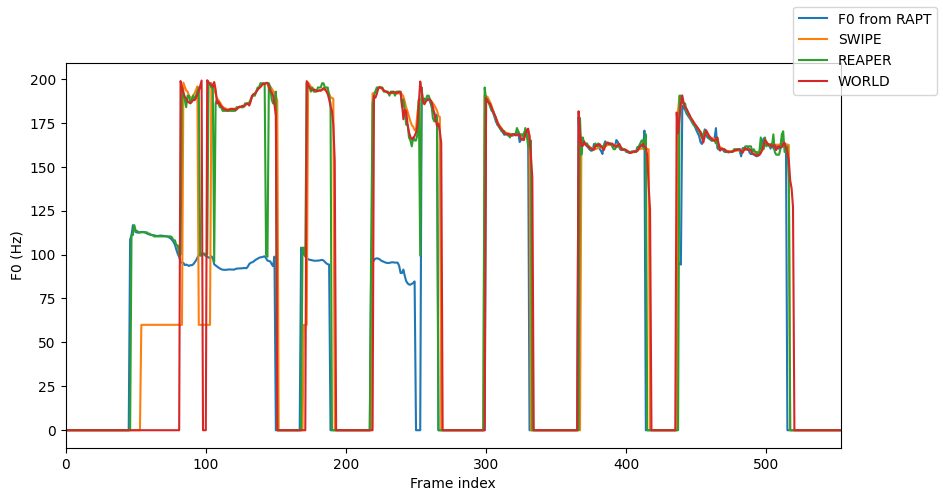

In [23]:
# We can load the SPTK output (little-endian, float32)
f0_rapt = tool_lib.read_raw_mat('/content/{:s}_1.f0'.format(filename), 1)
f0_swipe = tool_lib.read_raw_mat('/content/{:s}_2.f0'.format(filename), 1)
f0_reaper = tool_lib.read_raw_mat('/content/{:s}_3.f0'.format(filename), 1)
f0_world = tool_lib.read_raw_mat('/content/{:s}_4.f0'.format(filename), 1)

fig = plt.figure()
axis = fig.add_subplot(111)
plot_lib.plot_signal(f0_rapt, fig, axis)
plot_lib.plot_signal(f0_swipe, fig, axis)
plot_lib.plot_signal(f0_reaper, fig, axis)
plot_lib.plot_signal(f0_world, fig, axis, xlabel='Frame index', ylabel='F0 (Hz)')
fig.legend(['F0 from RAPT', 'SWIPE', 'REAPER', 'WORLD'])

# Sec.2 Re-synthesis

We will use MLSA filter to resynthesize the waveform

In [24]:
# prepare data in double format

!x2x +fd /content/${FILENAME}.mgc > /content/${FILENAME}_d.mgc

!excite -p 80 ${FILENAME}_4.pit | \
    mglsadf -p 80 -m 24 -a 0.42 /content/${FILENAME}_d.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav /content/${FILENAME}.syn.wav

In [25]:

import IPython.display
IPython.display.display("Original wav")
IPython.display.display(IPython.display.Audio("/content/data_models/acoustic_features/hn_nsf/{:s}.wav".format(filename)))
IPython.display.display("Copy-synthesized wav")
IPython.display.display(IPython.display.Audio("/content/{:s}.syn.wav".format(filename)))

'Original wav'

'Copy-synthesized wav'

# License
```
BSD 3-Clause License

Copyright (c) 2022, Xin Wang, National Institute of Informatics
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

The used audio sample is from [CMU Arctic database](http://www.festvox.org/cmu_arctic/):

```
Kominek, John, and Alan W. Black. "The CMU Arctic speech databases." Fifth ISCA workshop on speech synthesis. 2004.
```

```
This voice is free for use for any purpose (commercial or otherwise)
subject to the pretty light restrictions detailed below.

############################################################################
###                                                                       ##
###                     Carnegie Mellon University                        ##
###                         Copyright (c) 2003                            ##
###                        All Rights Reserved.                           ##
###                                                                       ##
###  Permission to use, copy, modify,  and licence this software and its  ##
###  documentation for any purpose, is hereby granted without fee,        ##
###  subject to the following conditions:                                 ##
###   1. The code must retain the above copyright notice, this list of    ##
###      conditions and the following disclaimer.                         ##
###   2. Any modifications must be clearly marked as such.                ##
###   3. Original authors' names are not deleted.                         ##
###                                                                       ##
###  THE AUTHORS OF THIS WORK DISCLAIM ALL WARRANTIES WITH REGARD TO      ##
###  THIS SOFTWARE, INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY   ##
###  AND FITNESS, IN NO EVENT SHALL THE AUTHORS BE LIABLE FOR ANY         ##
###  SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES            ##
###  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN   ##
###  AN ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION,          ##
###  ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF       ##
###  THIS SOFTWARE.                                                       ##
###                                                                       ##
############################################################################
###                                                                       ##
###  See http://www.festvox.org/cmu_arctic/ for more details              ##
###                                                                       ##
############################################################################

```

# ACKNOWLEDGEMENT

We thank Dr. Yoshimura for creating the colab tutorial for SPTK.

We thank the authors of SPTK for providing the open-sourced tools.

We thank CMU for providing the CMU Arctic database.

This work is partially supported by JST CREST Grants (JPMJCR18A6 and JPMJCR20D3), MEXT KAKENHI Grants (21K17775, 21H04906).